Framework
- Obtain data: Airline condition(daliy), weather(hourly)
- Feature engineering: quantify(string -> number), create factors, join tables
- Daily and hourly perspectives
- Initial data analysis and exploration
  - Exploratory data analysis: distributions, correlations, outliers
  - Data visualization: Correlation between weather and airplane delay time
- Data preprocessing
- Model selection
- Supervised learning: MLP, Logistic regression, RandomForest, LSTM/AGRU/GRU
- Unsupervised learing: K-means cluster(classification)
- Model Evaluation: E.g., Accuracy, Precision, Recall, F1-Score, ROC-AUC, Mean Absolute Error (MAE), R-squared and etc.
- Forecast

Airport condition
- Columns: "flightDate", "flightNo", "regNo", "status", "destAirportName", "ptd", "atd", "depDelayTime", "eta"
- Keys: ptd, atd, depDelayTime

Weather
- Temperature: 27.0°C (80.6°F)
- Heat index: 30.1°C (86.2°F)
- Dew point: 24.0°C (75.2°F)
- Winds: 11.7 kts (6 m/s, 13.4 mph) South-Southeast (160°)
- Visibility: 6.2 mi. (10 km)
- Clouds: Ceiling: Broken clouds 3,000 ft. (914 m)
- Altimeter: 29.83 in.Hg (1010 mB)
- Relative humidity: 84 %
- Density altitude: 1,892 ft. (577 m)
- Remarks: No significant changes expected in the next two hours
- Flight conditions: Visual Meteorological Conditions
- Raw data: ZGSZ 010000Z 16006MPS 9999 BKN030 27/24 Q1010 NOSIG

Time
- Beijing time zone (+8h)

In [322]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import os
# import pycaret
# import scipy
# print(pycaret.__version__)

path = os.getcwd() + '/'
Airport = pd.read_csv(path + 'Airport.csv',
                      parse_dates=["flightDate"])
Weather = pd.read_csv(path + "Weather_api.csv",
                      parse_dates=["Date"])

In [218]:
Airport_features = []
Airport_label = ['ptd_time']

In [219]:
Airport.fillna(0, inplace=True)
Airport

,flightDate,flightNo,regNo,status,destAirportName,ptd,atd,depDelayTime,depTerminal,gate,eta
0,2024-04-19,5X6077,0,到达,安克雷奇泰德史蒂文斯国际,08:50,0,0,0,待定,14:31
1,2024-04-19,ZH8017,B1477,到达,胡志明市新山一国际,23:40,00:01,延误21,T3,2,01:15
2,2024-04-19,ZH9005,B6855,到达,曼谷素万那普国际,23:50,00:04,延误14,T3,11,01:27
3,2024-04-19,MU5350,B6099,到达,上海虹桥,18:30,00:07,延误337,T3,506,01:51
4,2024-04-19,DZ6259,B1575,到达,海口美兰,23:59,00:09,延误10,T3,48,01:10
...,...,...,...,...,...,...,...,...,...,...,...
21381,2024-05-19,CA1736,0,取消,杭州萧山,23:55,0,0,T3,0,0
21382,2024-05-19,ZH1736,0,取消,杭州萧山,23:55,0,0,T3,0,0
21383,2024-05-19,CZ6923,B30ED,备降到达,昆明长水,20:10,20:27,延误17,T3,527,02:12
21384,2024-05-19,3U1927,B30ED,备降到达,昆明长水,20:10,20:27,延误17,T3,527,02:12


In [220]:
Airport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21386 entries, 0 to 21385
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   flightDate       21386 non-null  datetime64[ns]
 1   flightNo         21386 non-null  object        
 2   regNo            21386 non-null  object        
 3   status           21386 non-null  object        
 4   destAirportName  21386 non-null  object        
 5   ptd              21386 non-null  object        
 6   atd              21386 non-null  object        
 7   depDelayTime     21386 non-null  object        
 8   depTerminal      21386 non-null  object        
 9   gate             21386 non-null  object        
 10  eta              21386 non-null  object        
dtypes: datetime64[ns](1), object(10)
memory usage: 1.8+ MB


#### ptd

In [221]:
def combine_datetime(row):
    flight_date = row['flightDate']
    hours, minutes = map(int, row['ptd'].split(':'))
    ptd = pd.Timedelta(hours=hours, minutes=minutes)
    return flight_date + ptd
Airport["ptd_time"] = Airport.apply(combine_datetime, axis=1)
Airport["ptd_time"]

0       2024-04-19 08:50:00
1       2024-04-19 23:40:00
2       2024-04-19 23:50:00
3       2024-04-19 18:30:00
4       2024-04-19 23:59:00
                ...        
21381   2024-05-19 23:55:00
21382   2024-05-19 23:55:00
21383   2024-05-19 20:10:00
21384   2024-05-19 20:10:00
21385   2024-05-19 20:10:00
Name: ptd_time, Length: 21386, dtype: datetime64[ns]

In [222]:
# Add a timestamp to each airline (Relative to 0:00 of the day)
start_of_day = Airport['ptd_time'].dt.floor('D')  # 0:00 of the day
Airport['Timestamp/mins'] = (Airport['ptd_time'] - start_of_day).dt.total_seconds() / 60

#### Status

In [223]:
Airport["status"].unique()

array(['到达', '取消', '备降本场', '起飞', '备降到达', '返航到达', '延误', '备降取消'],
      dtype=object)

In [224]:
Airport["status"].value_counts()

status
到达      18994
取消       2257
起飞         35
备降本场       30
备降到达       28
延误         24
返航到达       12
备降取消        6
Name: count, dtype: int64

- 解释
    - 到达：成功抵达，保留
    - 取消：取消航班， 保留
    - 起飞：受到时差影响的异常记录，保留
    - 备降本场：受到飞机目标机场状况影响，迫降到本机场，去除
    - 备降到达：飞机备降到非目标机场，保留
    - 延误：信息丢失，去除
    - 返航到达：飞机出现故障返航或者飞机从目的地返航到始发地，保留
    - 备降取消：只是取消备降，保留

In [225]:
Airport = Airport[~Airport['status'].isin(['备降本场', '延误'])].copy()

In [226]:
Airport['status'].unique()

array(['到达', '取消', '起飞', '备降到达', '返航到达', '备降取消'], dtype=object)

#### ptd_time

In [227]:
def Weather_date(row):
    minutes = row['ptd_time'].minute
    time = row['ptd_time'] - timedelta(minutes=minutes)
    return time
Airport["Weather_date"] = Airport.apply(Weather_date, axis=1)
Airport["Weather_date"]

0       2024-04-19 08:00:00
1       2024-04-19 23:00:00
2       2024-04-19 23:00:00
3       2024-04-19 18:00:00
4       2024-04-19 23:00:00
                ...        
21381   2024-05-19 23:00:00
21382   2024-05-19 23:00:00
21383   2024-05-19 20:00:00
21384   2024-05-19 20:00:00
21385   2024-05-19 20:00:00
Name: Weather_date, Length: 21332, dtype: datetime64[ns]

#### depDelayTime

In [228]:
# Delay preprocess
def convert_delay(value):
    if isinstance(value, str):
        if '延误' in value:
            return -int(value.replace('延误', ''))
        elif '提前' in value:
            return int(value.replace('提前', ''))
    return 0

Airport['depDelayTime_Num/mins'] = Airport['depDelayTime'].apply(convert_delay)
Airport['depDelayTime_Num/mins']

0          0
1        -21
2        -14
3       -337
4        -10
        ... 
21381      0
21382      0
21383    -17
21384    -17
21385    -17
Name: depDelayTime_Num/mins, Length: 21332, dtype: int64

For analysis convenience purpose, we treat cancel status as infinity delay. The delay time is **(max delay time) * 10**

In [229]:
# infinity_delay_time = min(Airport['depDelayTime_Num/mins']) * 10
# print('infinity delay time: ', infinity_delay_time)
# def Cancel_time(row):
#     if row['status'] == '取消':
#         return infinity_delay_time
#     else: return row['depDelayTime_Num/mins']
# Airport['depDelayTime_Num/mins'] = Airport.apply(Cancel_time, axis=1)

### Weather

In [230]:
Weather.columns

Index(['Date', 'Temperature', 'Dew point', 'Winds', 'Visibility', 'Clouds',
       'Altimeter', 'Relative humidity', 'Density altitude', 'Remarks',
       'Flight conditions', 'Raw data', 'Heat index', 'Present weather',
       'Wind gusts', 'Winds variable'],
      dtype='object')

In [231]:
Weather.head(2)

,Date,Temperature,Dew point,Winds,Visibility,Clouds,Altimeter,Relative humidity,Density altitude,Remarks,Flight conditions,Raw data,Heat index,Present weather,Wind gusts,Winds variable
0,2024-04-19 00:00:00,26.0°C (78.8°F),22.0°C (71.6°F),"7.8 kts (4 m/s, 8.9 mph) East-Southeast (110°)",6.2 mi. (10 km),"Scattered clouds 3,000 ft. (914 m)",29.80 in.Hg (1009 mB),79 %,"1,770 ft. (540 m)",No significant changes expected in the next tw...,Visual Meteorological Conditions,ZGSZ 181600Z 11004MPS 9999 SCT030 26/22 Q1009 ...,NaN,NaN,NaN,NaN
1,2024-04-19 01:00:00,26.0°C (78.8°F),22.0°C (71.6°F),"7.8 kts (4 m/s, 8.9 mph) East-Southeast (110°)",6.2 mi. (10 km),"Scattered clouds 3,600 ft. (1,097 m)",29.77 in.Hg (1008 mB),79 %,"1,804 ft. (550 m)",No significant changes expected in the next tw...,Visual Meteorological Conditions,ZGSZ 181700Z 11004MPS 9999 SCT036 26/22 Q1008 ...,NaN,NaN,NaN,NaN


In [232]:
Weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               744 non-null    datetime64[ns]
 1   Temperature        744 non-null    object        
 2   Dew point          744 non-null    object        
 3   Winds              744 non-null    object        
 4   Visibility         576 non-null    object        
 5   Clouds             721 non-null    object        
 6   Altimeter          744 non-null    object        
 7   Relative humidity  744 non-null    object        
 8   Density altitude   744 non-null    object        
 9   Remarks            622 non-null    object        
 10  Flight conditions  744 non-null    object        
 11  Raw data           744 non-null    object        
 12  Heat index         270 non-null    object        
 13  Present weather    162 non-null    object        
 14  Wind gusts

#### Add daily date

In [233]:
def Daily(value):
    # Add a new column with year-month-day format
    return value.strftime('%Y-%m-%d')
Weather['Daily'] = Weather['Date'].apply(Daily)
Weather['Daily']

0      2024-04-19
1      2024-04-19
2      2024-04-19
3      2024-04-19
4      2024-04-19
          ...    
739    2024-05-19
740    2024-05-19
741    2024-05-19
742    2024-05-19
743    2024-05-19
Name: Daily, Length: 744, dtype: object

#### Temperature/Dew point/Relative humidity/Density altitude/Altimeter

In [234]:
def Object2Num(value):
    splitt = value.split("°")
    return float(splitt[0])
Weather['Temperature_Num/°C'] = Weather['Temperature'].apply(Object2Num)
Weather['Temperature_Num/°C']

0      26.0
1      26.0
2      26.0
3      26.0
4      26.0
       ... 
739    25.0
740    25.0
741    25.0
742    25.0
743    25.0
Name: Temperature_Num/°C, Length: 744, dtype: float64

In [235]:
Weather['Dew_point_Num/°C'] = Weather['Dew point'].apply(Object2Num)
Weather['Dew_point_Num/°C']

0      22.0
1      22.0
2      23.0
3      23.0
4      24.0
       ... 
739    22.0
740    22.0
741    22.0
742    23.0
743    22.0
Name: Dew_point_Num/°C, Length: 744, dtype: float64

In [236]:
def humidity(value):
    splitt = value.split(" ")
    return float(splitt[0])
Weather['Relative_humidity_Num/%'] = Weather['Relative humidity'].apply(humidity)
Weather['Relative_humidity_Num/%']

0      79.0
1      79.0
2      84.0
3      84.0
4      89.0
       ... 
739    83.0
740    83.0
741    83.0
742    89.0
743    83.0
Name: Relative_humidity_Num/%, Length: 744, dtype: float64

In [237]:
Weather['Density altitude'].unique()

array(['1,770 ft. (540 m)', '1,804 ft. (550 m)', '1,859 ft. (567 m)',
       '1,893 ft. (577 m)', '1,881 ft. (573 m)', '1,994 ft. (608 m)',
       '2,072 ft. (632 m)', '2,050 ft. (625 m)', '2,106 ft. (642 m)',
       '1,939 ft. (591 m)', '2,028 ft. (618 m)', '2,062 ft. (628 m)',
       '1,960 ft. (597 m)', '1,938 ft. (591 m)', '2,217 ft. (676 m)',
       '2,184 ft. (666 m)', '2,038 ft. (621 m)', '1,837 ft. (560 m)',
       '1,984 ft. (605 m)', '2,017 ft. (615 m)', '2,163 ft. (659 m)',
       '2,174 ft. (663 m)', '1,625 ft. (495 m)', '1,363 ft. (415 m)',
       '1,329 ft. (405 m)', '1,261 ft. (384 m)', '1,295 ft. (395 m)',
       '1,410 ft. (430 m)', '1,443 ft. (440 m)', '1,477 ft. (450 m)',
       '1,591 ft. (485 m)', '1,577 ft. (481 m)', '1,544 ft. (471 m)',
       '1,214 ft. (370 m)', '1,396 ft. (425 m)', '1,430 ft. (436 m)',
       '1,645 ft. (501 m)', '1,490 ft. (454 m)', '1,510 ft. (460 m)',
       '1,464 ft. (446 m)', '1,497 ft. (456 m)', '1,736 ft. (529 m)',
       '1,758 ft. (5

在标准大气条件下，空气的密度是已知的，这是基于大气科学对标准大气模型的理解所确定的。当我们谈论密度高度时，我们实际上是在比较某一高度处的空气密度与标准大气条件下相同密度的空气所处的高度。

举个例子，假设在某一高度上，空气的密度与标准大气条件下1000英尺处的空气密度相同，那么我们就可以说该高度的密度高度为1000英尺。这意味着尽管实际高度可能不是1000英尺，但由于空气密度与标准条件下的1000英尺处相同，所以我们可以将这一高度称为密度高度1000英尺。

In [238]:
def Altitude(value):
    value1 = value.split('(')[1].split(' ')
    num = value1[0]
    unit = value1[1].split(')')[0]
    if unit == 'km':
        return float(num) * 1000
    elif unit == 'm':
        return float(num)
Weather['Density_altitude_Num/m'] = Weather['Density altitude'].apply(Altitude)
Weather['Density_altitude_Num/m']

0      540.0
1      550.0
2      567.0
3      577.0
4      573.0
       ...  
739    536.0
740    536.0
741    526.0
742    532.0
743    515.0
Name: Density_altitude_Num/m, Length: 744, dtype: float64

In [239]:
Weather['Altimeter'].unique()

array(['29.80 in.Hg (1009 mB)', '29.77 in.Hg (1008 mB)',
       '29.74 in.Hg (1007 mB)', '29.71 in.Hg (1006 mB)',
       '29.68 in.Hg (1005 mB)', '29.83 in.Hg (1010 mB)',
       '29.88 in.Hg (1012 mB)', '29.65 in.Hg (1004 mB)',
       '29.62 in.Hg (1003 mB)', '29.59 in.Hg (1002 mB)',
       '29.56 in.Hg (1001 mB)', '29.85 in.Hg (1011 mB)',
       '29.91 in.Hg (1013 mB)', '29.94 in.Hg (1014 mB)',
       '29.97 in.Hg (1015 mB)', '30.00 in.Hg (1016 mB)'], dtype=object)

In [240]:
def Altimeter(value):
    value1 = value.split('(')[1].split(" ")
    return float(value1[0])
Weather['Altimeter_Num/mb'] = Weather['Altimeter'].apply(Altimeter)
Weather['Altimeter_Num/mb']

0      1009.0
1      1008.0
2      1007.0
3      1006.0
4      1007.0
        ...  
739    1006.0
740    1006.0
741    1007.0
742    1007.0
743    1008.0
Name: Altimeter_Num/mb, Length: 744, dtype: float64

#### Visibility
- NaN: replace with 100 km

1. 能见度20-30公里 能见度极好 视野清晰
2. 能见度15-25公里 能见度好 视野较清晰
3. 能见度10-20公里 能见度一般
4. 能见度5-15公里 能见度较差 视野不清晰
5. 能见度1-10公里 轻雾 能见度差 视野不清晰
6. 能见度0.3-1公里 大雾 能见度很差
7. 能见度小于0.3公里 重雾 能见度极差
8. 能见度小于0.1公里 浓雾 能见度极差
9. 能见度不足100米通常被认为为零

In [241]:
Weather['Visibility'] = Weather['Visibility'].fillna('62.0 mi. (100 km)')
Weather['Visibility'].unique()

array(['6.2 mi. (10 km)', '62.0 mi. (100 km)', '3.7 mi. (6 km)',
       '5 mi. (8 km)', '4.3 mi. (7 km)', '5.6 mi. (9 km)',
       '1968.5 ft. (600 m)', '3.1 mi. (5 km)', '2.5 mi. (4 km)',
       '2.2 mi. (3.5 km)', '3937 ft. (1.2 km)', '1.2 mi. (2 km)',
       '1.7 mi. (2.8 km)', '2.8 mi. (4.5 km)', '1.9 mi. (3 km)'],
      dtype=object)

In [242]:
def Visibility(value):
    value1 = value.split('(')[1].split(' ')
    num = value1[0]
    unit = value1[1].split(')')[0]
    if unit == 'km':
        return float(num)
    elif unit == 'm':
        return float(num)/1000
Weather['Visibility_Num/km'] = Weather['Visibility'].apply(Visibility)
Weather['Visibility_Num/km']

0      10.0
1      10.0
2      10.0
3      10.0
4      10.0
       ... 
739    10.0
740     8.0
741    10.0
742    10.0
743    10.0
Name: Visibility_Num/km, Length: 744, dtype: float64

#### Winds

Formatter:
- '7.8 kts (4 m/s, 8.9 mph) East-Southeast (110°)'
- 'Calm': Wind "CALM" means a wind speed less than 0.5m/s (1 kt)

1. Replace Calm with: '1.0 kts (0.5 m/s, 2.2 mph) Vrb'

- Vrb: when the total variation is 60° or more and less than 180° and the wind speed is 6 km/h (3 kt) or more, such directional variations shall be reported as the two extreme directions between which the surface wind has varied

2. For convenience purpose, We use last hour's wind angle when appears Vrb
3. We have known that the direction of ZGSZ is 63°. Therefore, we should calculate the included angle between runway and wind direction

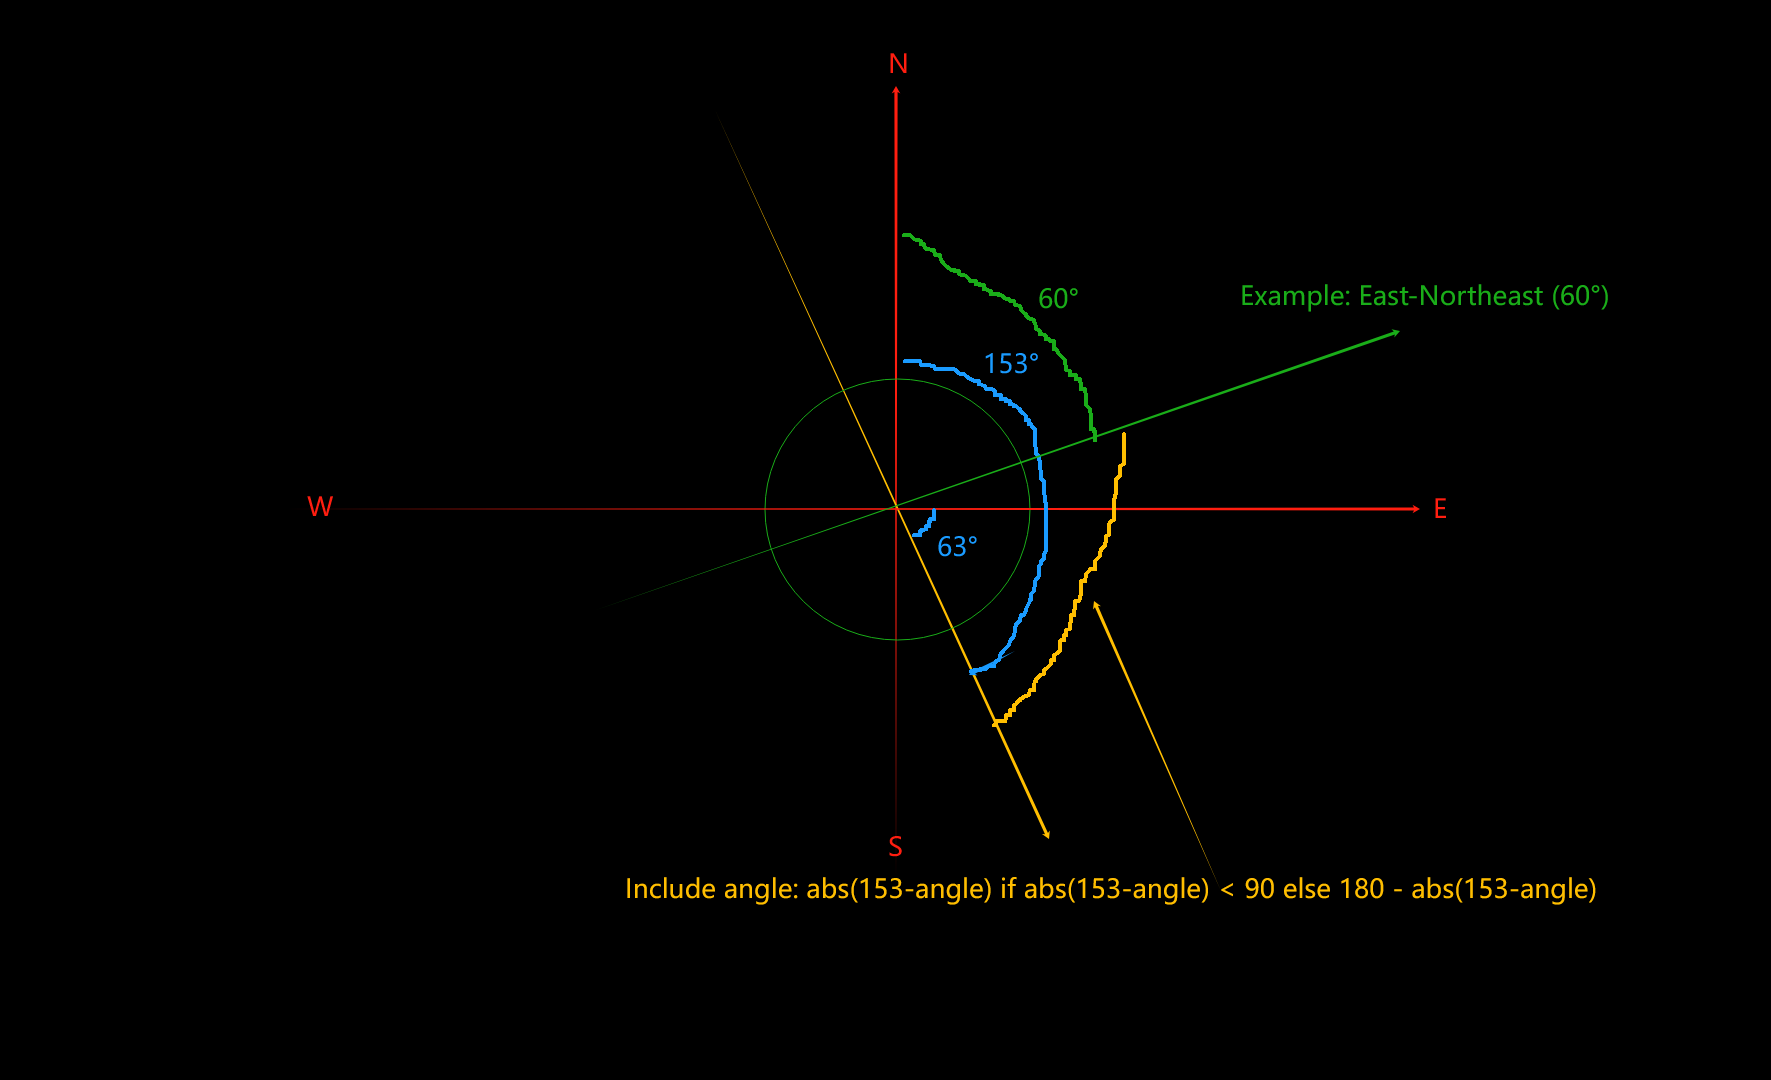

4. Winds variable: Vrb_bool
5. Winds gusts: Winds_gusts_bool

In [243]:
Weather['Winds'] = Weather['Winds'].replace("Calm", "1.0 kts (0.5 m/s, 2.2 mph) Vrb")

In [244]:
def Wind_Speed(value):
    value1 = value.split("(")[1]
    value2 = value1.split(" m/s")
    return float(value2[0])
Weather['Wind_Speed/m/s'] = Weather['Winds'].apply(Wind_Speed)
Weather['Wind_Speed/m/s']

0      4.0
1      4.0
2      4.0
3      4.0
4      4.0
      ... 
739    2.0
740    1.0
741    3.0
742    3.0
743    1.0
Name: Wind_Speed/m/s, Length: 744, dtype: float64

In [245]:
def Wind_Angle(value):
    combine = value.split('mph) ')[1]
    if combine == 'Vrb':
        return None
    else:
        # direction = combine.split(' (')[0]
        angle = float(combine.split(' (')[1].split("°")[0])
        # ZGSZ runway angle = 153
        included_angle = abs(153 - angle) if abs(153 - angle) < 90 else abs(180 - abs(153 - angle))
        return included_angle
Weather['Winds_Included_Angle/°'] = Weather['Winds'].apply(Wind_Angle)
# Use forward value
Weather['Winds_Included_Angle/°'] = Weather['Winds_Included_Angle/°'].ffill()
Weather['Winds_Included_Angle/°']

0      43.0
1      43.0
2      43.0
3      43.0
4      43.0
       ... 
739    43.0
740    43.0
741    77.0
742    77.0
743    77.0
Name: Winds_Included_Angle/°, Length: 744, dtype: float64

In [246]:
Weather['Vrb_bool'] = Weather['Winds variable'].notnull().astype(int)
Weather['Vrb_bool']

0      0
1      0
2      0
3      0
4      0
      ..
739    1
740    1
741    0
742    1
743    1
Name: Vrb_bool, Length: 744, dtype: int32

In [247]:
Weather['Wind_gusts_bool'] = Weather['Wind gusts'].notnull().astype(int)
Weather['Wind_gusts_bool']

0      0
1      0
2      0
3      0
4      0
      ..
739    0
740    0
741    0
742    0
743    0
Name: Wind_gusts_bool, Length: 744, dtype: int32

#### Clouds

Clouds condition analysis is much complex than others. Let's not do that for now.

In [248]:
# def number(num: str):
#     # '1,234' to '1234'
#     num = num.split(',')
#     return ''.join(num)

# def Clouds_Layer_Num(value):
#     splitt = str(value).split(") ")
#     if splitt[0] == 'Sky clear':
#         return str(splitt)
#     layer_list = []
#     for item in splitt:
#         if item.endswith(")"):
#             layer_list.append(item)
#         else: layer_list.append(item + ')')
#     return str(layer_list)
# Weather['Clouds'].apply(Clouds_Layer_Num).unique()

In [249]:
Weather['Clouds'].unique()

array(['Scattered clouds 3,000 ft. (914 m)',
       'Scattered clouds 3,600 ft. (1,097 m)',
       'Few clouds 2,100 ft. (640 m) Scattered clouds 3,600 ft. (1,097 m)',
       'Sky clear',
       'Few clouds 3,000 ft. (914 m) Scattered clouds 5,000 ft. (1,524 m)',
       'Few clouds 3,000 ft. (914 m)',
       'Few clouds 2,300 ft. (701 m) Ceiling: Broken clouds 3,300 ft. (1,006 m)',
       'Few clouds 2,300 ft. (701 m)',
       'Few clouds 2,200 ft. (671 m) Few clouds with cumulonimbus 3,300 ft. (1,006 m)',
       'Few clouds 1,800 ft. (549 m) Few clouds with cumulonimbus 2,400 ft. (732 m)',
       'Few clouds 1,800 ft. (549 m) Few clouds with cumulonimbus 2,700 ft. (823 m) Ceiling: Broken clouds 4,000 ft. (1,219 m)',
       'Few clouds 1,800 ft. (549 m) Few clouds with cumulonimbus 4,000 ft. (1,219 m) Ceiling: Broken clouds 5,000 ft. (1,524 m)',
       'Few clouds 1,800 ft. (549 m) Ceiling: Broken clouds 5,000 ft. (1,524 m)',
       'Few clouds 1,800 ft. (549 m) Ceiling: Broken clouds 

#### Remarks

In [250]:
Weather['Remarks'].unique()

array(['No significant changes expected in the next two hours',
       'Ceiling and visibility OK No significant changes expected in the next two hours',
       nan, 'Ceiling and visibility OK'], dtype=object)

#### Flight conditions

1. **Visual Meteorological Conditions (VMC)**:
   - Meaning: Good weather conditions where pilots can navigate and control the aircraft visually, typically under clear skies or with scattered clouds that do not significantly affect flight.

2. **Marginal Visual Meteorological Conditions (MVFR)**:
   - Meaning: Conditions allowing for visual navigation, but with reduced visibility (between 3 to 5 miles) or cloud ceilings (between 1000 to 3000 feet) that impose some restrictions on flight.

3. **Low Instrument Meteorological Conditions (LIMC)**:
   - Meaning: Weather conditions requiring Instrument Flight Rules (IFR) due to very low visibility or near-ground cloud ceilings, necessitating instrument navigation and control.

4. **Instrument Meteorological Conditions (IMC)**:
   - Meaning: Poor weather conditions where visibility is very low (less than 3 miles) or cloud ceilings are low (below 1000 feet), requiring exclusive reliance on instrument flight rules for navigation and control.

In [251]:
Weather['Flight conditions'].unique()

array(['Visual Meteorological Conditions',
       'Marginal Visual Meteorological Conditions',
       'Low Instrument Meteorological Conditions',
       'Instrument Meteorological Conditions'], dtype=object)

#### Heat Index

There are a lot of missing values.

In [252]:
Weather['Heat index'].unique()

array([nan, '30.1°C (86.2°F)', '32.0°C (89.6°F)', '31.4°C (88.5°F)',
       '29.7°C (85.5°F)', '33.7°C (92.7°F)', '30.6°C (87.0°F)',
       '32.7°C (90.9°F)', '29.3°C (84.8°F)', '34.6°C (94.3°F)',
       '33.5°C (92.3°F)', '31.1°C (87.9°F)', '36.8°C (98.2°F)',
       '38.9°C (101.9°F)', '35.6°C (96.1°F)', '35.2°C (95.4°F)',
       '34.2°C (93.6°F)', '35.5°C (95.9°F)', '28.2°C (82.7°F)',
       '29.2°C (84.5°F)', '31.5°C (88.6°F)', '31.0°C (87.7°F)',
       '31.9°C (89.4°F)', '30.5°C (87.0°F)', '28.0°C (82.3°F)',
       '28.7°C (83.7°F)', '29.9°C (85.8°F)', '31.0°C (87.8°F)',
       '30.8°C (87.5°F)', '30.4°C (86.6°F)', '29.0°C (84.2°F)',
       '32.2°C (90.0°F)', '33.4°C (92.1°F)', '32.9°C (91.2°F)',
       '28.4°C (83.2°F)', '27.0°C (80.6°F)', '27.5°C (81.5°F)',
       '28.6°C (83.5°F)', '29.7°C (85.4°F)', '29.5°C (85.2°F)',
       '30.5°C (86.9°F)', '28.8°C (83.9°F)', '28.3°C (83.0°F)',
       '27.8°C (82.0°F)', '31.6°C (88.8°F)'], dtype=object)

### Present weather

In [253]:
Weather['Present weather'].unique()

array([nan, 'Light rain showers', 'Thunderstorm',
       'Light thunderstorm with rain',
       'Light thunderstorm with rain, recent rain showers',
       'Thunderstorms in the vicinity', 'Heavy rain showers',
       'Heavy thunderstorm with rain', 'Thunderstorm with rain',
       'Heavy thunderstorm with rain, light thunderstorm with rain',
       'Light rain showers, recent rain showers', 'Rain showers',
       'Thunderstorm with rain, mist', 'Recent rain showers', 'RETS',
       'Light rain showers, RETS', 'Mist', 'Light rain showers, RETSRA',
       'Heavy rain showers, RETS',
       'Thunderstorms in the vicinity, light rain showers', 'RETSRA',
       'Light rain showers, rain showers', 'Light rain'], dtype=object)

#### Thunderstorm

There are four conditions for thunderstorm
- No storm: 0
- Light storm: 1
- Moderate storm: 2
- Heavy storm: 3

In [254]:
# Conditions dict
Contitions_dict = {
    'heavy thunderstorm': 3,
    'light thunderstorm': 2,
    'thunderstorm': 1
}
Contitions_dict.items()

dict_items([('heavy thunderstorm', 3), ('light thunderstorm', 2), ('thunderstorm', 1)])

In [255]:
def storm(value):
    condition = str(value).lower()
    for key, value in Contitions_dict.items():
        if key in condition:
            return value
    return 0
Weather['Thunderstorm/index'] = Weather['Present weather'].apply(storm)
Weather['Thunderstorm/index']

0      0
1      0
2      0
3      0
4      0
      ..
739    0
740    0
741    0
742    0
743    0
Name: Thunderstorm/index, Length: 744, dtype: int64

In [256]:
dict(zip(Weather['Present weather'], Weather['Thunderstorm/index']))

{nan: 0,
 'Light rain showers': 0,
 'Thunderstorm': 1,
 'Light thunderstorm with rain': 2,
 'Light thunderstorm with rain, recent rain showers': 2,
 'Thunderstorms in the vicinity': 1,
 'Heavy rain showers': 0,
 'Heavy thunderstorm with rain': 3,
 'Thunderstorm with rain': 1,
 'Heavy thunderstorm with rain, light thunderstorm with rain': 3,
 'Light rain showers, recent rain showers': 0,
 'Rain showers': 0,
 'Thunderstorm with rain, mist': 1,
 'Recent rain showers': 0,
 'RETS': 0,
 'Light rain showers, RETS': 0,
 'Mist': 0,
 'Light rain showers, RETSRA': 0,
 'Heavy rain showers, RETS': 0,
 'Thunderstorms in the vicinity, light rain showers': 1,
 'RETSRA': 0,
 'Light rain showers, rain showers': 0,
 'Light rain': 0}

### Rainfall

In [257]:
Rainfall = pd.read_csv('Rainfall.csv', parse_dates=['Date'])

In [258]:
Rainfall

,Date,Rainfall/mm
0,2024-04-01,13.56
1,2024-04-02,0.38
2,2024-04-03,0.81
3,2024-04-04,0.46
4,2024-04-05,3.06
...,...,...
71,2024-06-11,4.01
72,2024-06-12,1.19
73,2024-06-13,0.40
74,2024-06-14,41.43


### Airport-Weather

In [259]:
Flight_date = ['flightDate']
Weather_date = ['Weather_date']
ptd_time = ['ptd_time']
Weather_Features = [
    "Temperature_Num/°C",
    "Dew_point_Num/°C",
    "Relative_humidity_Num/%",
    "Density_altitude_Num/m",
    "Visibility_Num/km",
    "Wind_Speed/m/s",
    "Winds_Included_Angle/°",
    "Vrb_bool",
    "Wind_gusts_bool",
    "Altimeter_Num/mb",
    "Thunderstorm/index"
]
Delay_time = ['depDelayTime_Num/mins']
Cancled_bool = ['Cancled_bool']
Timestamp = ['Timestamp/mins']

Processed_Features = [
    "Temperature_Num",
    "Dew_point_Num",
    "Relative_humidity_Num",
    "Density_altitude_Num",
    "Visibility_Num",
    "Wind_Speed",
    "Winds_Included_Angle",
    "Vrb_bool",
    "Wind_gusts_bool",
    "Altimeter_Num",
    "Thunderstorm",
    "Timestamp/mins"
]

Questions:
- What is the correlation between **Daily Cancle times** and **Rainfall**, **Temperature**, **Dew point**, **humidity**

In [260]:
Airport_Weather = pd.merge(Airport, Weather, left_on='Weather_date', right_on='Date', how='left')
Airport_Weather

,flightDate,flightNo,regNo,status,destAirportName,ptd,atd,depDelayTime,depTerminal,gate,...,Dew_point_Num/°C,Relative_humidity_Num/%,Density_altitude_Num/m,Altimeter_Num/mb,Visibility_Num/km,Wind_Speed/m/s,Winds_Included_Angle/°,Vrb_bool,Wind_gusts_bool,Thunderstorm/index
0,2024-04-19,5X6077,0,到达,安克雷奇泰德史蒂文斯国际,08:50,0,0,0,待定,...,24.0,79.0,632.0,1008.0,10.0,7.0,7.0,0,0,0
1,2024-04-19,ZH8017,B1477,到达,胡志明市新山一国际,23:40,00:01,延误21,T3,2,...,23.0,79.0,591.0,1008.0,100.0,5.0,3.0,0,0,0
2,2024-04-19,ZH9005,B6855,到达,曼谷素万那普国际,23:50,00:04,延误14,T3,11,...,23.0,79.0,591.0,1008.0,100.0,5.0,3.0,0,0,0
3,2024-04-19,MU5350,B6099,到达,上海虹桥,18:30,00:07,延误337,T3,506,...,24.0,84.0,618.0,1006.0,10.0,7.0,7.0,0,0,0
4,2024-04-19,DZ6259,B1575,到达,海口美兰,23:59,00:09,延误10,T3,48,...,23.0,79.0,591.0,1008.0,100.0,5.0,3.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21327,2024-05-19,CA1736,0,取消,杭州萧山,23:55,0,0,T3,0,...,22.0,83.0,515.0,1008.0,10.0,1.0,77.0,1,0,0
21328,2024-05-19,ZH1736,0,取消,杭州萧山,23:55,0,0,T3,0,...,22.0,83.0,515.0,1008.0,10.0,1.0,77.0,1,0,0
21329,2024-05-19,CZ6923,B30ED,备降到达,昆明长水,20:10,20:27,延误17,T3,527,...,22.0,83.0,536.0,1006.0,8.0,1.0,43.0,1,0,0
21330,2024-05-19,3U1927,B30ED,备降到达,昆明长水,20:10,20:27,延误17,T3,527,...,22.0,83.0,536.0,1006.0,8.0,1.0,43.0,1,0,0


### Hourly Analysis

##### Delay time Regression (Exclude Cancle airlines)(Regression)

In [261]:
# Delete Cancled airlines
Airport_Weather_hourly = Airport_Weather[Airport_Weather['status'] != '取消']
Airport_Weather_hourly = Airport_Weather[Weather_date + ptd_time + Weather_Features + Delay_time + Timestamp]
Airport_Weather_hourly

,Weather_date,ptd_time,Temperature_Num/°C,Dew_point_Num/°C,Relative_humidity_Num/%,Density_altitude_Num/m,Visibility_Num/km,Wind_Speed/m/s,Winds_Included_Angle/°,Vrb_bool,Wind_gusts_bool,Altimeter_Num/mb,Thunderstorm/index,depDelayTime_Num/mins,Timestamp/mins
0,2024-04-19 08:00:00,2024-04-19 08:50:00,28.0,24.0,79.0,632.0,10.0,7.0,7.0,0,0,1008.0,0,0,530.0
1,2024-04-19 23:00:00,2024-04-19 23:40:00,27.0,23.0,79.0,591.0,100.0,5.0,3.0,0,0,1008.0,0,-21,1420.0
2,2024-04-19 23:00:00,2024-04-19 23:50:00,27.0,23.0,79.0,591.0,100.0,5.0,3.0,0,0,1008.0,0,-14,1430.0
3,2024-04-19 18:00:00,2024-04-19 18:30:00,27.0,24.0,84.0,618.0,10.0,7.0,7.0,0,0,1006.0,0,-337,1110.0
4,2024-04-19 23:00:00,2024-04-19 23:59:00,27.0,23.0,79.0,591.0,100.0,5.0,3.0,0,0,1008.0,0,-10,1439.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21327,2024-05-19 23:00:00,2024-05-19 23:55:00,25.0,22.0,83.0,515.0,10.0,1.0,77.0,1,0,1008.0,0,0,1435.0
21328,2024-05-19 23:00:00,2024-05-19 23:55:00,25.0,22.0,83.0,515.0,10.0,1.0,77.0,1,0,1008.0,0,0,1435.0
21329,2024-05-19 20:00:00,2024-05-19 20:10:00,25.0,22.0,83.0,536.0,8.0,1.0,43.0,1,0,1006.0,0,-17,1210.0
21330,2024-05-19 20:00:00,2024-05-19 20:10:00,25.0,22.0,83.0,536.0,8.0,1.0,43.0,1,0,1006.0,0,-17,1210.0


In [262]:
Airport_Weather_hourly[Weather_Features + Delay_time + Timestamp].describe()

,Temperature_Num/°C,Dew_point_Num/°C,Relative_humidity_Num/%,Density_altitude_Num/m,Visibility_Num/km,Wind_Speed/m/s,Winds_Included_Angle/°,Vrb_bool,Wind_gusts_bool,Altimeter_Num/mb,Thunderstorm/index,depDelayTime_Num/mins,Timestamp/mins
count,21332.000000,21332.000000,21332.000000,21332.000000,21332.000000,21332.000000,21332.000000,21332.000000,21332.000000,21332.000000,21332.000000,21332.000000,21332.000000
mean,26.263032,21.516126,76.946231,536.408963,32.902995,3.812755,43.849991,0.370383,0.023205,1010.022642,0.108757,-41.057941,846.843287
std,1.897435,3.122546,14.761183,77.872967,39.851583,1.812555,24.800168,0.482918,0.150556,3.445988,0.448443,80.613757,329.118001
min,21.000000,9.000000,27.000000,358.000000,0.600000,0.500000,3.000000,0.000000,0.000000,1001.000000,0.000000,-1276.000000,5.000000
25%,25.000000,20.000000,69.000000,481.000000,10.000000,2.000000,27.000000,0.000000,0.000000,1007.000000,0.000000,-35.000000,560.000000
50%,26.000000,22.000000,79.000000,536.000000,10.000000,4.000000,43.000000,0.000000,0.000000,1010.000000,0.000000,-16.000000,835.000000
75%,28.000000,23.000000,89.000000,591.000000,100.000000,5.000000,67.000000,1.000000,0.000000,1013.000000,0.000000,-7.000000,1135.000000
max,31.000000,27.000000,100.000000,763.000000,100.000000,10.000000,87.000000,1.000000,1.000000,1016.000000,3.000000,136.000000,1439.000000


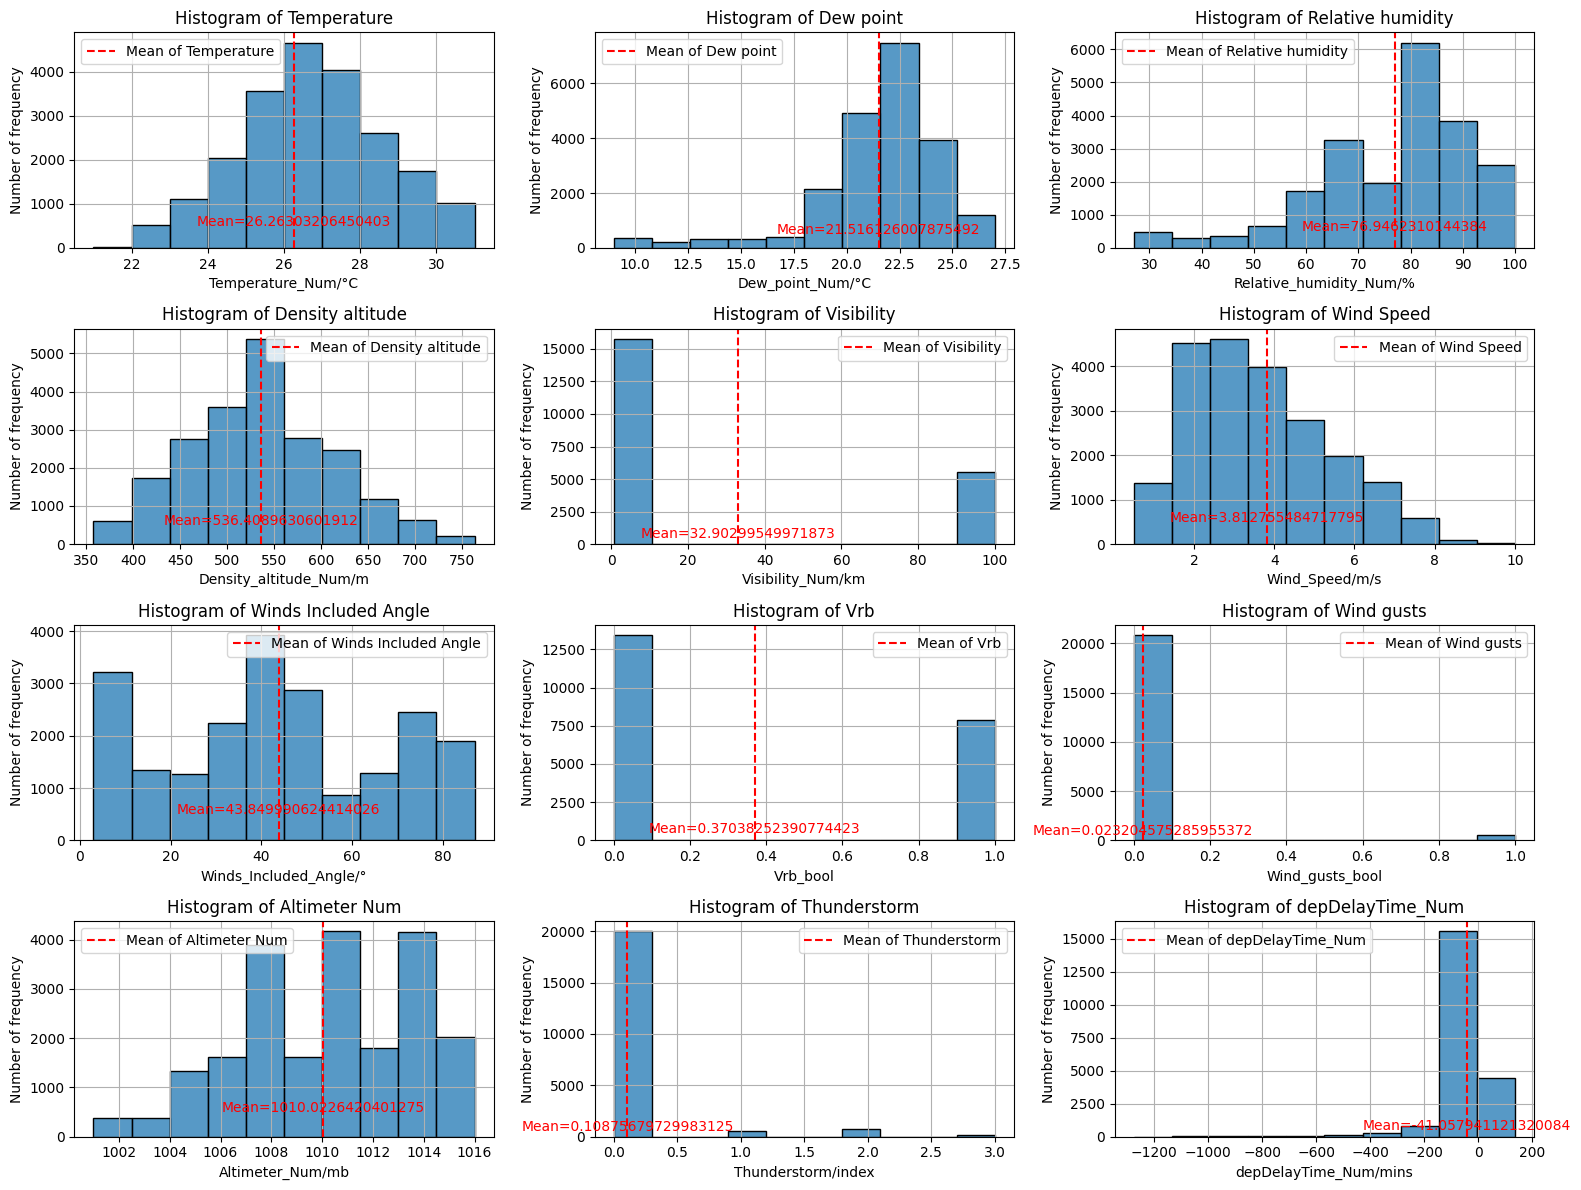

In [263]:
### Feature distribution diagram

Histogram_Features = Weather_Features + Delay_time
Histogram_Labels = [
    [True, "Temperature"],
    [True, "Dew point"],
    [True, "Relative humidity"],
    [True, "Density altitude"],
    [True, "Visibility"],
    [True, "Wind Speed"],
    [True, "Winds Included Angle"],
    [True, "Vrb"],
    [True, "Wind gusts"],
    [True, "Altimeter Num"],
    [True, "Thunderstorm"],
    [True, 'depDelayTime_Num']
]

plt.figure(figsize=(16, 12))
def Draw_Histogram(DF, Feature, Bin, Kde, 
                   Name, Axvline=False, 
                   Axvline_label=False):
    sns.histplot(
        data=DF, x=Feature, bins=Bin, kde=Kde
    )  # kde is the parameter that shows the trendline
    if Axvline:
        mean = np.mean(DF[Feature])
        plt.axvline(x=mean, color='r', linestyle='--', label= 'Mean of ' + Axvline_label)
        plt.annotate(f'Mean={mean}', xy=(mean, 0), xytext=(mean, 500),
                     color='r', ha='center')
        plt.legend()
    plt.title(f"Histogram of {Name}")
    plt.xlabel(f"{Feature}")
    plt.ylabel("Number of frequency")
    plt.grid(True)

# Iterate over the features and create subplots
for i, feature in enumerate(Histogram_Features):
    plt.subplot(4, 3, i+1)
    Draw_Histogram(Airport_Weather_hourly, feature, 
                   Bin=10, Kde=False, 
                   Name=Histogram_Labels[i][1],
                   Axvline=Histogram_Features[i][0],
                   Axvline_label=Histogram_Labels[i][1])

plt.tight_layout()
plt.show()

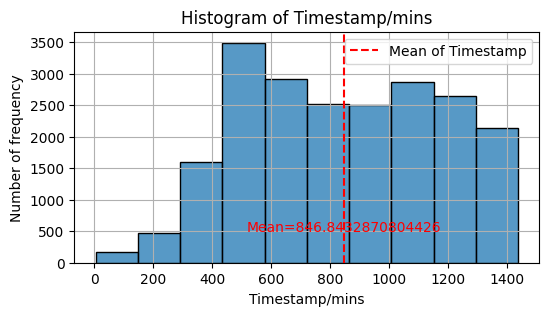

In [264]:
plt.figure(figsize=(6, 3))

# Histogram of Sleep duration
sns.histplot(data=Airport_Weather_hourly, 
             x='Timestamp/mins', 
             bins=10, kde=False)
means = np.mean(Airport_Weather_hourly['Timestamp/mins'])
plt.axvline(x=means, color='r', linestyle='--', label= 'Mean of ' + 'Timestamp')
plt.annotate(f'Mean={means}', xy=(means, 0), xytext=(means, 500),
                color='r', ha='center')
plt.title("Histogram of Timestamp/mins")
plt.xlabel("Timestamp/mins")
plt.ylabel("Number of frequency")
plt.grid(True)
plt.legend()
plt.show()

In [265]:
### Data preprocessing
zscore = StandardScaler()

hourly_X_processed = zscore.fit_transform(Airport_Weather_hourly[Weather_Features + Timestamp])
hourly_y = Airport_Weather_hourly[Delay_time].values
hourly_processed = zscore.fit_transform(Airport_Weather_hourly[Weather_Features + Timestamp])
hourly_X_processed_df = pd.DataFrame(hourly_X_processed, index=Airport_Weather_hourly.index, columns=Processed_Features)
hourly_y_df = pd.DataFrame(hourly_y, index=Airport_Weather_hourly.index, columns=[Delay_time])
hourly_processed_df = pd.DataFrame(hourly_processed, index=Airport_Weather_hourly.index, columns=Processed_Features)
hourly_processed_df['depDelayTime_Num/mins'] = Airport_Weather_hourly['depDelayTime_Num/mins']

In [266]:
# Draw_Histogram(Airport_Weather_hourly,
#                'Temperature_Num/°C',
#                10, False, 'Temperature/°C')

# Draw_Histogram(Airport_Weather_hourly,
#                'Winds_Included_Angle/°',
#                15, False, 'Winds Included Angle/°',)

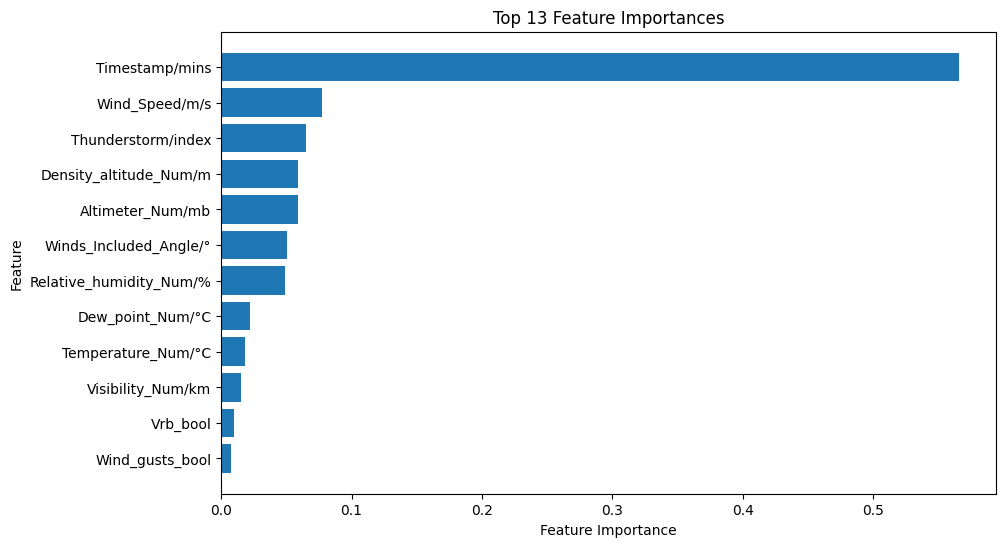

In [267]:
### Feature importance
### Use Random Forest Regression

feature_names = Weather_Features + Timestamp
X_train = hourly_X_processed
y_train = hourly_y.reshape(-1)

fi_rf = RandomForestRegressor(n_estimators=20, random_state=42)
fi_rf.fit(X_train, y_train)

# access feature_importances_ attribute
importances = fi_rf.feature_importances_

# Sort feature importances in descending order and select the top ten
N = 13
top_indices = np.argsort(importances)[::-1][:N]
top_feature_importances = importances[top_indices]
top_feature_names = [feature_names[i] for i in top_indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_feature_importances)), top_feature_importances, align='center')
plt.yticks(range(len(top_feature_importances)), top_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title(f'Top {N} Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top
plt.show()

In [268]:
### Use VIF
# import matplotlib.pyplot as plt

def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data['Features'] = df.columns # All features
    vif_data['VIF'] = [VIF(df.values, i) for i in range(len(df.columns))] # Calculate vif values for features
    vif_data = vif_data.sort_values(by='VIF', ascending=False) # Sort vif values use descending
    vif_data.reset_index(drop=True, inplace=True)
    return vif_data
calculate_vif(hourly_processed_df)

,Features,VIF
0,Density_altitude_Num,3139.062493
1,Temperature_Num,2659.028464
2,Altimeter_Num,660.411716
3,Relative_humidity_Num,95.946777
4,Dew_point_Num,60.596299
5,Visibility_Num,1.690040
6,Wind_Speed,1.679882
7,Winds_Included_Angle,1.608399
8,Vrb_bool,1.408346
9,Thunderstorm,1.322964


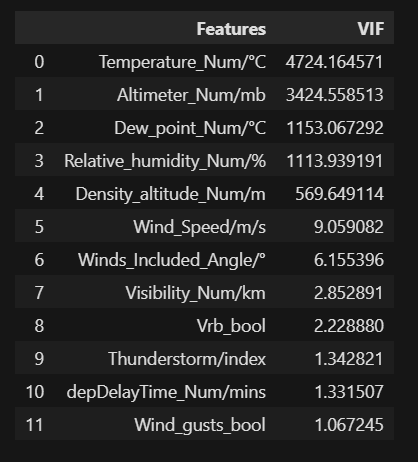

In [269]:
### Remove high VIF features

def Remove_high_vif(df):
    vif_data = calculate_vif(df)
    Largest_vif = vif_data.iloc[0]['VIF'] # Get the largest vif value feature
    if Largest_vif > 10: # if it larger than 10, drop it
        drop_features = vif_data.iloc[0]['Features']
    else: drop_features = None # else, do nothing
    print('Drop:', drop_features)
    print('Largest vif:', Largest_vif)
    print()
    return drop_features

XX = hourly_processed_df
while True:
    drop_features = Remove_high_vif(XX)
    if drop_features:
        XX = XX.drop(drop_features, axis=1)
    else: break
Final_vif_data = calculate_vif(XX)
Final_vif_data

# def remove_high_vif_features(df, threshold=10):
#     # Calculate VIF values
#     vif_data = calculate_vif(df)
    
#     # Get features with VIF above threshold
#     high_vif_features = vif_data[vif_data['VIF'] > threshold]['Features'].tolist()
    
#     # Apply PCA to remove high VIF features
#     pca = PCA()
#     reduced_features = df.drop(high_vif_features, axis=1)
#     reduced_features_pca = pca.fit_transform(reduced_features)
    
#     # Print the variance explained by each principal component
#     print("Variance explained by each principal component:")
#     print(pca.explained_variance_ratio_)
    
#     return reduced_features_pca

# # Remove high VIF features using PCA
# reduced_features_pca = remove_high_vif_features(Airport_Weather_hourly[Weather_Features + Delay_time])
# reduced_features_pca

Drop: Density_altitude_Num
Largest vif: 3139.0624926858127

Drop: Relative_humidity_Num
Largest vif: 38.27430199564595

Drop: None
Largest vif: 2.1686142727356637



,Features,VIF
0,Dew_point_Num,2.168614
1,Altimeter_Num,2.024768
2,Wind_Speed,1.678328
3,Visibility_Num,1.673014
4,Winds_Included_Angle,1.493034
5,Vrb_bool,1.396625
6,Temperature_Num,1.371840
7,Thunderstorm,1.211068
8,depDelayTime_Num/mins,1.080882
9,Timestamp/mins,1.057202


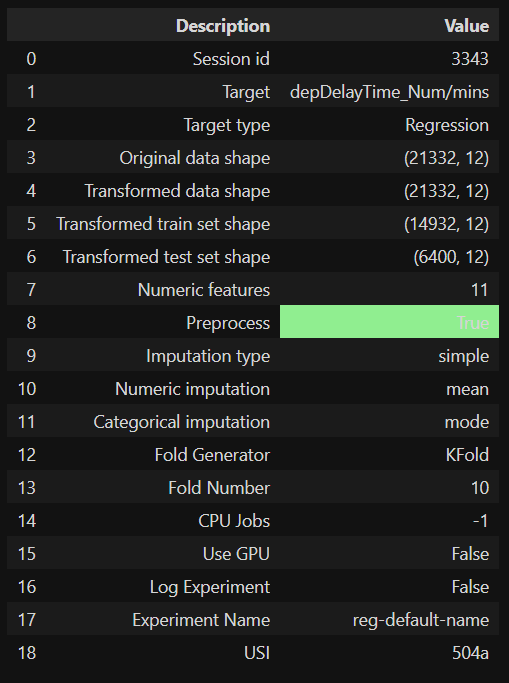

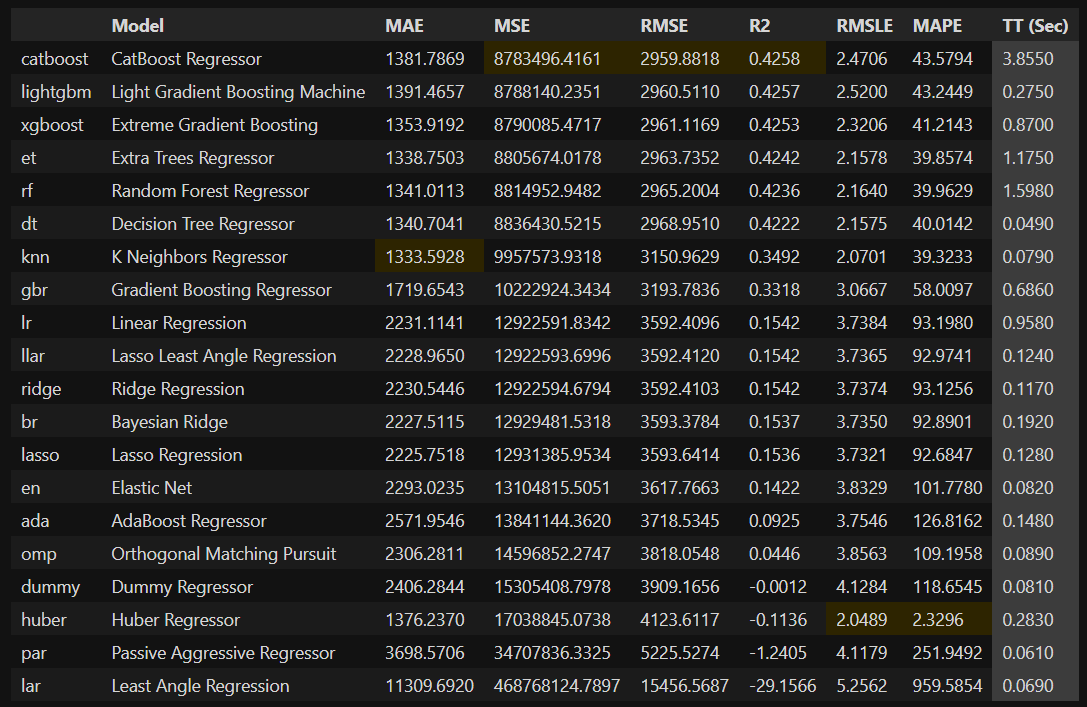

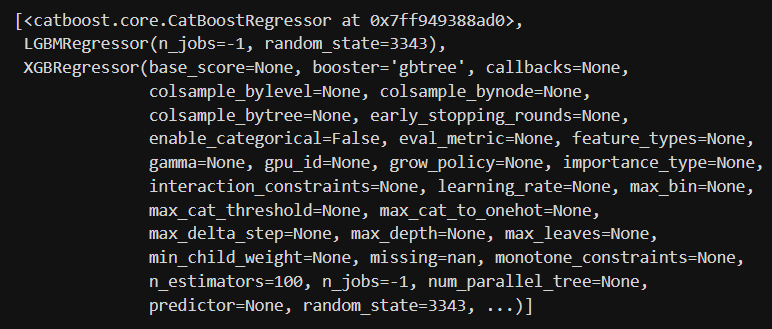

In [280]:
### Split

In [290]:
hourly_X_processed_train, hourly_X_processed_test = train_test_split(
    hourly_X_processed, test_size=0.2, shuffle=False)
hourly_y_train, hourly_y_test = train_test_split(
    hourly_y, test_size=0.2, shuffle=False)
hourly_X_processed_train_df, hourly_X_processed_test_df = train_test_split(
    hourly_X_processed_df, test_size=0.2, shuffle=False)
hourly_y_train_df, hourly_y_test_df = train_test_split(
    hourly_X_processed_df, test_size=0.2, shuffle=False)

In [ ]:
# Setup the PyCaret environment
from pycaret.regression import (
    setup as setup_reg,
    models as models_reg,
    compare_models as compare_models_reg,
    predict_model as predict_model_reg,
    save_model as save_model_reg,
    load_model as load_model_reg,
)

In [270]:
### AutoML

# data_train = hourly_X_processed_train_df[Weather_Features + Delay_time]
# data_test = hourly_X_processed_test_df[Weather_Features + Delay_time]
# clf1 = setup_reg(data_train, 
#                 target='depDelayTime_Num/mins')
# # List all available models
# models_reg()

In [271]:
# Compare
# best_model_reg = compare_models_reg(sort='MSE', n_select=3)
# best_model_reg

In [272]:
# Make predictions on the test set using the best model
# predictions_reg = predict_model_reg(best_model_reg[0], data=data_test)

# Save the best model
# save_model_reg(best_model_reg, 'best_model_Airport_Weather_hourly')
# # Load the saved model back into memory
# loaded_model_reg = load_model_reg('best_model_Airport_Weather_hourly')

The table shows the metrics of the model, including Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), R-squared (R2), Root Mean Squared Logarithmic Error (RMSLE), and Mean Absolute Percentage Error (MAPE). Here is a brief explanation of each metric:

1. **MAE (Mean Absolute Error)**:
   - Mean Absolute Error is the average absolute difference between predicted values and actual values. A lower MAE indicates a higher accuracy of the model's predictions. $ MAE = \frac{1}{n} \sum_{i=1}^{n} |actual_i - predicted_i| $

2. **MSE (Mean Squared Error)**:
   - Mean Squared Error is the average of the squared differences between predicted values and actual values. A lower MSE indicates that the model's predictions are closer to the actual values. $ MSE = \frac{1}{n} \sum_{i=1}^{n} (actual_i - predicted_i)^2 $

3. **RMSE (Root Mean Squared Error)**:
   - Root Mean Squared Error is the square root of the Mean Squared Error. It measures the standard deviation of the differences between predicted values and actual values. A lower RMSE indicates a higher accuracy of the model's predictions. $ RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (actual_i - predicted_i)^2} $

4. **R2 (R-squared)**:
   - R-squared is a measure of how well the model fits the data, ranging between 0 and 1. An R2 closer to 1 indicates that the model can explain a significant portion of the variance in the target variable. $ R^2 = 1 - \frac{\sum_{i=1}^{n} (actual_i - predicted_i)^2}{\sum_{i=1}^{n} (actual_i - \bar{actual})^2} $

5. **RMSLE (Root Mean Squared Logarithmic Error)**:
   - Root Mean Squared Logarithmic Error is the average of the logarithmic differences between predicted values and actual values. A lower RMSLE indicates that the model is more sensitive to larger errors. $ RMSLE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (\log(predicted_i + 1) - \log(actual_i + 1))^2} $

6. **MAPE (Mean Absolute Percentage Error)**:
   - Mean Absolute Percentage Error is the average of the absolute percentage differences between predicted values and actual values. A lower MAPE indicates a smaller percentage error of the model. $ MAPE = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{actual_i - predicted_i}{actual_i} \right| $

#### Cancled Airlines Analysis (Classification)

In [273]:
def Cancled_Airlines(value):
    value_str = str(value)
    if value_str == '取消':
        return 1
    else: return 0

In [274]:
Airport_Weather['status'].apply(Cancled_Airlines)

0        0
1        0
2        0
3        0
4        0
        ..
21327    1
21328    1
21329    0
21330    0
21331    0
Name: status, Length: 21332, dtype: int64

In [275]:
# Cancled airlines Analysis
Airport_Weather_hourly_Cancled = Airport_Weather.copy()
Airport_Weather_hourly_Cancled['Cancled_bool'] = Airport_Weather_hourly_Cancled['status'].apply(Cancled_Airlines)
Airport_Weather_hourly_Cancled

,flightDate,flightNo,regNo,status,destAirportName,ptd,atd,depDelayTime,depTerminal,gate,...,Relative_humidity_Num/%,Density_altitude_Num/m,Altimeter_Num/mb,Visibility_Num/km,Wind_Speed/m/s,Winds_Included_Angle/°,Vrb_bool,Wind_gusts_bool,Thunderstorm/index,Cancled_bool
0,2024-04-19,5X6077,0,到达,安克雷奇泰德史蒂文斯国际,08:50,0,0,0,待定,...,79.0,632.0,1008.0,10.0,7.0,7.0,0,0,0,0
1,2024-04-19,ZH8017,B1477,到达,胡志明市新山一国际,23:40,00:01,延误21,T3,2,...,79.0,591.0,1008.0,100.0,5.0,3.0,0,0,0,0
2,2024-04-19,ZH9005,B6855,到达,曼谷素万那普国际,23:50,00:04,延误14,T3,11,...,79.0,591.0,1008.0,100.0,5.0,3.0,0,0,0,0
3,2024-04-19,MU5350,B6099,到达,上海虹桥,18:30,00:07,延误337,T3,506,...,84.0,618.0,1006.0,10.0,7.0,7.0,0,0,0,0
4,2024-04-19,DZ6259,B1575,到达,海口美兰,23:59,00:09,延误10,T3,48,...,79.0,591.0,1008.0,100.0,5.0,3.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21327,2024-05-19,CA1736,0,取消,杭州萧山,23:55,0,0,T3,0,...,83.0,515.0,1008.0,10.0,1.0,77.0,1,0,0,1
21328,2024-05-19,ZH1736,0,取消,杭州萧山,23:55,0,0,T3,0,...,83.0,515.0,1008.0,10.0,1.0,77.0,1,0,0,1
21329,2024-05-19,CZ6923,B30ED,备降到达,昆明长水,20:10,20:27,延误17,T3,527,...,83.0,536.0,1006.0,8.0,1.0,43.0,1,0,0,0
21330,2024-05-19,3U1927,B30ED,备降到达,昆明长水,20:10,20:27,延误17,T3,527,...,83.0,536.0,1006.0,8.0,1.0,43.0,1,0,0,0


In [278]:
hourly_Cancled_X_processed = zscore.fit_transform(Airport_Weather_hourly_Cancled[Weather_Features + Timestamp])
hourly_Cancled_y = Airport_Weather_hourly_Cancled[Cancled_bool].values
hourly_Cancled_processed = zscore.fit_transform(Airport_Weather_hourly_Cancled[Weather_Features + Timestamp])
hourly_Cancled_X_processed_df = pd.DataFrame(hourly_Cancled_X_processed, 
                                             index=Airport_Weather_hourly_Cancled.index, 
                                             columns=Processed_Features)
hourly_Cancled_y_df = pd.DataFrame(hourly_Cancled_y, 
                                   index=Airport_Weather_hourly_Cancled.index, 
                                   columns=Cancled_bool)
hourly_Cancled_processed_df = pd.DataFrame(hourly_Cancled_processed, 
                                           index=Airport_Weather_hourly_Cancled.index, 
                                           columns=Processed_Features)
hourly_Cancled_processed_df['Cancled_bool'] = Airport_Weather_hourly_Cancled['Cancled_bool']

In [292]:
hourly_Cancled_X_processed_train, hourly_Cancled_X_processed_test = train_test_split(
    hourly_Cancled_X_processed, test_size=0.2, shuffle=False)
hourly_Cancled_y_train, hourly_Cancled_y_test = train_test_split(
    hourly_Cancled_y, test_size=0.2, shuffle=False)
hourly_Cancled_X_processed_train_df, hourly_Cancled_X_processed_test_df = train_test_split(
    hourly_Cancled_X_processed_df, test_size=0.2, shuffle=False)
hourly_Cancled_y_train_df, hourly_Cancled_y_test_df = train_test_split(
    hourly_Cancled_X_processed_df, test_size=0.2, shuffle=False)

In [296]:
### K-means cluster

In [309]:
Cancled_K_Means = KMeans(n_clusters=2)
K_Means_Model = Cancled_K_Means.fit(hourly_Cancled_X_processed_train)
y_train_predictions_kmean = Cancled_K_Means.predict(hourly_Cancled_X_processed_train)
y_test_predictions_kmean = Cancled_K_Means.predict(hourly_Cancled_X_processed_test)

In [310]:
print(classification_report(hourly_Cancled_y_train.reshape(-1), y_train_predictions_kmean))
print(classification_report(hourly_Cancled_y_test.reshape(-1), y_test_predictions_kmean))

              precision    recall  f1-score   support

           0       0.82      0.65      0.73     14890
           1       0.01      0.02      0.01      2175

    accuracy                           0.57     17065
   macro avg       0.42      0.34      0.37     17065
weighted avg       0.72      0.57      0.64     17065

              precision    recall  f1-score   support

           0       0.97      0.72      0.82      4185
           1       0.00      0.00      0.00        82

    accuracy                           0.70      4267
   macro avg       0.49      0.36      0.41      4267
weighted avg       0.95      0.70      0.81      4267



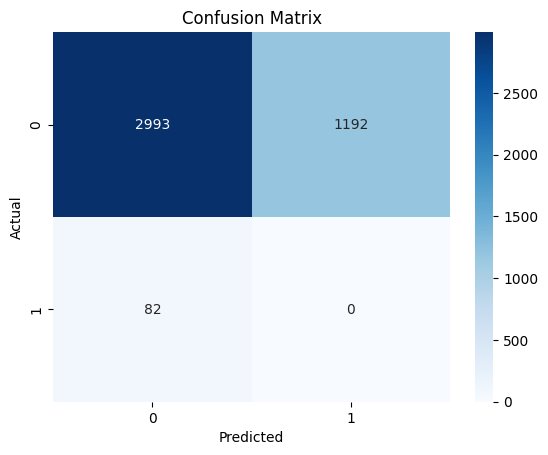

In [311]:
# Confusion matrix
conf_matrix = confusion_matrix(hourly_Cancled_y_test.reshape(-1), y_test_predictions_kmean)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [312]:
### SVM

D:\Python311_pip\site-packages\sklearn\utils\validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      4267
           1       0.00      0.00      0.00         0

    accuracy                           0.98      4267
   macro avg       0.50      0.49      0.50      4267
weighted avg       1.00      0.98      0.99      4267



D:\Python311_pip\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Python311_pip\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Python311_pip\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


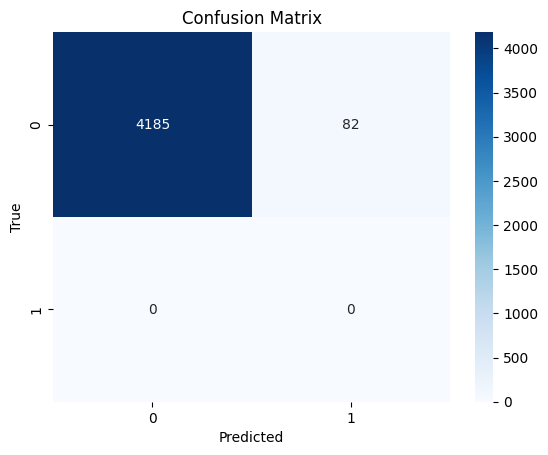

In [321]:
# Create an SVM classifier with RBF kernel
svm = SVC(kernel='rbf', gamma='scale')

# Train the model
svm.fit(hourly_Cancled_X_processed_train, hourly_Cancled_y_train)

# Predict the labels of the set
y_train_predictions_kmean = svm.predict(hourly_Cancled_X_processed_train)
y_test_predictions_kmean = svm.predict(hourly_Cancled_X_processed_test)

# Evaluate the model
accuracy = accuracy_score(y_test_predictions_kmean, hourly_Cancled_y_test)
conf_matrix = confusion_matrix(y_test_predictions_kmean, hourly_Cancled_y_test)
class_report = classification_report(y_test_predictions_kmean, hourly_Cancled_y_test)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(class_report)

# Plot the confusion matrix
plt.figure()
sns.heatmap(conf_matrix, 
            annot=True, 
            fmt='d', 
            cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
## AutoML
# Setup the PyCaret environment
from pycaret.classification import (
    setup as setup_cls,
    models as models_cls,
    compare_models as compare_models_cls,
    predict_model as predict_model_cls,
    save_model as save_model_cls,
    load_model as load_model_cls,
)

In [ ]:
data_train = hourly_Cancled_X_processed_train_df[Weather_Features + Cancled_bool]
data_test = hourly_Cancled_X_processed_test_df[Weather_Features + Cancled_bool]
clf1 = setup_cls(data_train, 
                target='Cancled_bool')
# List all available models
models_cls()

In [ ]:
# Compare
best_model_cls = compare_models_cls(sort='accuracy', n_select=3)
best_model_cls

In [ ]:
# Make predictions on the test set using the best model
predictions_cls = predict_model_cls(best_model_cls[0], data=data_test)

# Save the best model
save_model_cls(best_model_cls, 'best_model_Airport_Weather_hourly')
# Load the saved model back into memory
loaded_model_cls = load_model_cls('best_model_Airport_Weather_hourly')

#### Daily Analysis

In [314]:
# Because when the count is 0, it will be dropped automatically
flight_dates = pd.DataFrame({'flightDate': Airport_Weather['flightDate'].unique()})

In [315]:
Cancle_Daily = (
                Airport_Weather[Airport_Weather['status'] == '取消']
                .groupby(by='flightDate')['status']
                .count()
                .to_frame()
                .reset_index()
                .rename(columns={"status": "Cancle_times"})
                )
Cancle_Daily = flight_dates.merge(Cancle_Daily, on='flightDate', how='left')
Cancle_Daily['Cancle_times'] = Cancle_Daily['Cancle_times'].fillna(0).astype(int)

# Add Rainfall
Cancle_Daily = pd.merge(Cancle_Daily, 
                        Rainfall, 
                        left_on='flightDate', 
                        right_on='Date', 
                        how='left')
Cancle_Daily = Cancle_Daily.drop(columns=['Date'])

# Add All_airlines
Cancle_Daily['All_airlines'] = (
    Airport_Weather
    .groupby(by="flightDate")["status"]
    .count()
    .to_frame()
    .reset_index()
)['status']

# Calculate cancle rate
Cancle_Daily['Cancle_rate'] = Cancle_Daily['Cancle_times'] / Cancle_Daily['All_airlines']

Cancle_Daily['Avg_Delaytime'] = (
    Airport_Weather
    .groupby(by="flightDate")["depDelayTime_Num/mins"]
    .mean()
    .to_frame()
    .reset_index()
)['depDelayTime_Num/mins']

# Add Avg Temperature
Cancle_Daily['Avg_Temp/°C'] = (
    Airport_Weather
    .groupby(by="flightDate")["Temperature_Num/°C"]
    .mean()
    .to_frame()
    .reset_index()
)['Temperature_Num/°C']

# Add Avg Wind speed
Cancle_Daily['Avg_Wind_Speed/m/s'] = (
    Airport_Weather
    .groupby(by="flightDate")["Wind_Speed/m/s"]
    .mean()
    .to_frame()
    .reset_index()
)['Wind_Speed/m/s']

# Add Avg Angle
Cancle_Daily['Avg_Angle/°'] = (
    Airport_Weather
    .groupby(by="flightDate")["Winds_Included_Angle/°"]
    .mean()
    .to_frame()
    .reset_index()
)['Winds_Included_Angle/°']

# Add Avg Visibility
Cancle_Daily['Avg_Visibility/km'] = (
    Airport_Weather
    .groupby(by="flightDate")["Visibility_Num/km"]
    .mean()
    .to_frame()
    .reset_index()
)['Visibility_Num/km']

# Add Avg Thunderstorm
Cancle_Daily['Avg_Thunderstorm/index'] = (
    Airport_Weather
    .groupby(by="flightDate")["Thunderstorm/index"]
    .mean()
    .to_frame()
    .reset_index()
)['Thunderstorm/index']

# Add Avg Humidity
Cancle_Daily['Avg_Humidity/%'] = (
    Airport_Weather
    .groupby(by="flightDate")["Relative_humidity_Num/%"]
    .mean()
    .to_frame()
    .reset_index()
)["Relative_humidity_Num/%"]

# Add Avg Vrb
Cancle_Daily['Avg_Vrb/index'] = (
    Airport_Weather
    .groupby(by="flightDate")["Vrb_bool"]
    .mean()
    .to_frame()
    .reset_index()
)["Vrb_bool"]

# Add Avg Wind gust
Cancle_Daily['Avg_Wind_Gust/index'] = (
    Airport_Weather
    .groupby(by="flightDate")["Wind_gusts_bool"]
    .mean()
    .to_frame()
    .reset_index()
)["Wind_gusts_bool"]

# Add Avg Altimeter
Cancle_Daily['Avg_Altimeter/mb'] = (
    Airport_Weather
    .groupby(by="flightDate")["Altimeter_Num/mb"]
    .mean()
    .to_frame()
    .reset_index()
)["Altimeter_Num/mb"]

# Add Avg Density altitude
Cancle_Daily['Avg_Density_altitude/m'] = (
    Airport_Weather
    .groupby(by="flightDate")["Density_altitude_Num/m"]
    .mean()
    .to_frame()
    .reset_index()
)["Density_altitude_Num/m"]

# Add Avg Dewpoint
Cancle_Daily['Avg_Dew_point/°C'] = (
    Airport_Weather
    .groupby(by="flightDate")["Dew_point_Num/°C"]
    .mean()
    .to_frame()
    .reset_index()
)["Dew_point_Num/°C"]

Cancle_Daily

,flightDate,Cancle_times,Rainfall/mm,All_airlines,Cancle_rate,Avg_Delaytime,Avg_Temp/°C,Avg_Wind_Speed/m/s,Avg_Angle/°,Avg_Visibility/km,Avg_Thunderstorm/index,Avg_Humidity/%,Avg_Vrb/index,Avg_Wind_Gust/index,Avg_Altimeter/mb,Avg_Density_altitude/m,Avg_Dew_point/°C
0,2024-04-19,219,2.50,637,0.343799,-104.065934,27.191523,6.811617,8.874411,35.996860,0.240188,82.233909,0.000000,0.000000,1007.106750,612.160126,23.838305
1,2024-04-20,392,1.72,676,0.579882,-96.084320,25.291420,5.756361,32.139053,11.482249,0.745562,87.010355,0.226331,0.093195,1007.702663,534.119822,22.881657
2,2024-04-21,124,9.66,381,0.325459,-49.123360,23.643045,4.315748,40.868766,23.184252,0.461942,88.929134,0.246719,0.139108,1008.367454,462.595801,21.679790
3,2024-04-22,8,19.01,421,0.019002,-32.128266,24.947743,2.496437,31.546318,11.979810,0.118765,89.451306,0.280285,0.059382,1008.399050,516.206651,23.038005
4,2024-04-23,232,47.44,585,0.396581,-55.237607,24.817094,3.177778,24.117949,11.734701,0.545299,91.716239,0.314530,0.000000,1007.223932,525.960684,23.326496
5,2024-04-24,2,17.18,532,0.003759,-47.097744,25.539474,2.077068,48.533835,5.813346,0.157895,90.278195,0.218045,0.000000,1008.411654,541.293233,23.761278
6,2024-04-25,88,20.35,386,0.227979,-29.626943,26.510363,4.158031,28.150259,18.984456,0.000000,85.492228,0.365285,0.000000,1005.805699,601.979275,23.800518
7,2024-04-26,80,78.85,497,0.160966,-65.191147,26.301811,5.107445,19.704225,9.444668,0.267606,91.593561,0.154930,0.088531,1003.110664,629.953722,24.792757
8,2024-04-27,64,7.62,479,0.133612,-60.237996,28.043841,5.984969,7.158664,9.810021,0.000000,89.519833,0.000000,0.089770,1004.148225,688.365344,26.118998
9,2024-04-28,102,40.06,562,0.181495,-68.350534,25.912811,6.016014,37.032028,19.094306,0.008897,86.129893,0.177936,0.000000,1007.918149,556.761566,23.346975


##### Wind index
Considering that the wind influences both direction and speed, we should combine it with a new index
direction ↑, influence ↑
speed ↑, influence ↑
Wind index = 

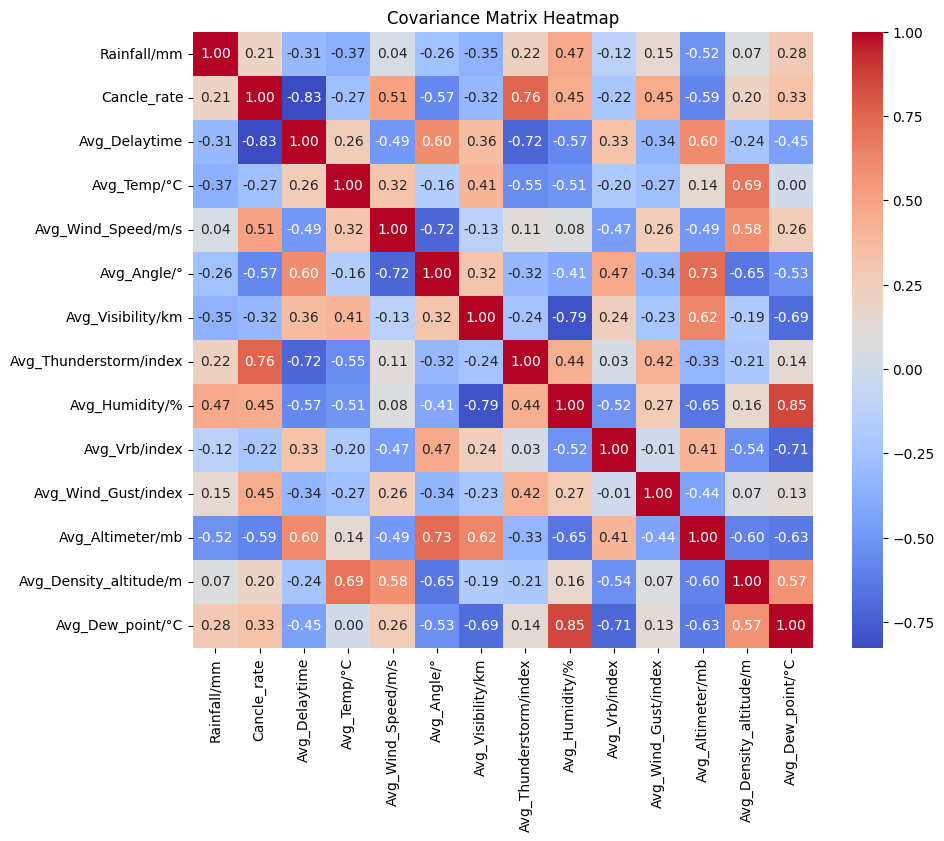

In [316]:
# Create Wind index
import seaborn as sns

df = Cancle_Daily[
   ["Rainfall/mm",
    "Cancle_rate",
    "Avg_Delaytime",
    "Avg_Temp/°C",
    "Avg_Wind_Speed/m/s",
    "Avg_Angle/°",
    "Avg_Visibility/km",
    "Avg_Thunderstorm/index",
    "Avg_Humidity/%",
    "Avg_Vrb/index",
    "Avg_Wind_Gust/index",
    "Avg_Altimeter/mb",
    "Avg_Density_altitude/m",
    "Avg_Dew_point/°C"]]

covariance_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(covariance_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 10})
plt.title('Covariance Matrix Heatmap')
plt.show()

In [320]:
# # Create a figure and a set of subplots
# fig, ax = plt.subplots(figsize=(10, 4.5))

# flightdate = Cancle_Daily["flightDate"]

# # # Plot Rainfall
# # ax.plot(flightdate, Cancle_Daily["Rainfall/mm"], label="Rainfall")

# # # plot Temp
# # ax.plot(flightdate, Cancle_Daily["Avg_Temp/°C"], label="Avg Temp")
# # ax.plot(
# #     flightdate,
# #     Cancle_Daily["Avg_Wind_Speed/m/s"] * 5,
# #     color="w",
# #     label="Avg Wind speed/m/s",
# # )  # Cancle rate data on the secondary y-axis

# # # plot Avg Angle
# # ax.plot(
# #     flightdate,
# #     Cancle_Daily["Avg_Angle/°"],
# #     color="#c52cd0",
# #     label="Avg Wind Angle/°",
# # )

# # plot Avg Thunderstorm
# ax.plot(
#     flightdate,
#     Cancle_Daily["Avg_Thunderstorm/index"],
#     color="w",
#     label="Avg Thunderstorm/index",
# )

# # # plot Avg Altimeter
# # ax.plot(
# #     flightdate,
# #     Cancle_Daily["Avg_Altimeter/mb"] / 1000,
# #     color="#fd8b2e",
# #     label="Avg Altimeter/mb",
# # )

# # plot Avg Wind Gust
# # ax.plot(
# #     flightdate,
# #     Cancle_Daily["Avg_Wind_Gust/index"],
# #     color="#9db42f",
# #     label="Avg Wind Gust/index",
# # )

# # plot Avg Vrb
# ax.plot(
#     flightdate,
#     Cancle_Daily["Avg_Vrb/index"],
#     color="#9db42f",
#     label="Avg Vrb/index",
# )

# # Set labels and title
# ax.set_xlabel("Date")
# ax.set_ylabel("Rainfall / Temp / Wind speed")
# ax.set_title("Cancle rate visualization")
# ax.legend(loc="upper right")

# # # Rotate x-axis labels for better visibility
# # plt.xticks(rotation=45)

# # Create a secondary y-axis for Cancle rate
# ax_secondary = ax.twinx()
# ax_secondary.plot(
#     flightdate,
#     Cancle_Daily["Cancle_rate"] * 100,
#     color="#d53b64",
#     marker="s",
#     label="Cancle rate",
# )  # Cancle rate data on the secondary y-axis
# ax_secondary.plot(
#     flightdate,
#     - Cancle_Daily["Avg_Delaytime"],
#     color="#4ef13f",
#     marker="^",
#     label="Avg Delay time",
# )  # Cancle rate data on the secondary y-axis

# ax_secondary.set_ylabel("Cancle rate / Avg Delay Time")
# ax_secondary.legend(loc="center right")

# # Rotate x-axis labels for better visibility
# # date = pd.Series(date.strftime('%Y-%m-%d') for date in Cancle_Daily['flightDate'])
# # ax.set_xticks(date)
# # ax.set_xticklabels(date, rotation=45)

# # # Format x-axis as dates
# # date_format = mdates.DateFormatter('%Y-%m-%d')
# # ax.xaxis.set_major_formatter(date_format)

# # Display the plot
# # Rotate x-axis labels
# ax.tick_params(axis="x", rotation=45)
# plt.tight_layout()
# plt.show()

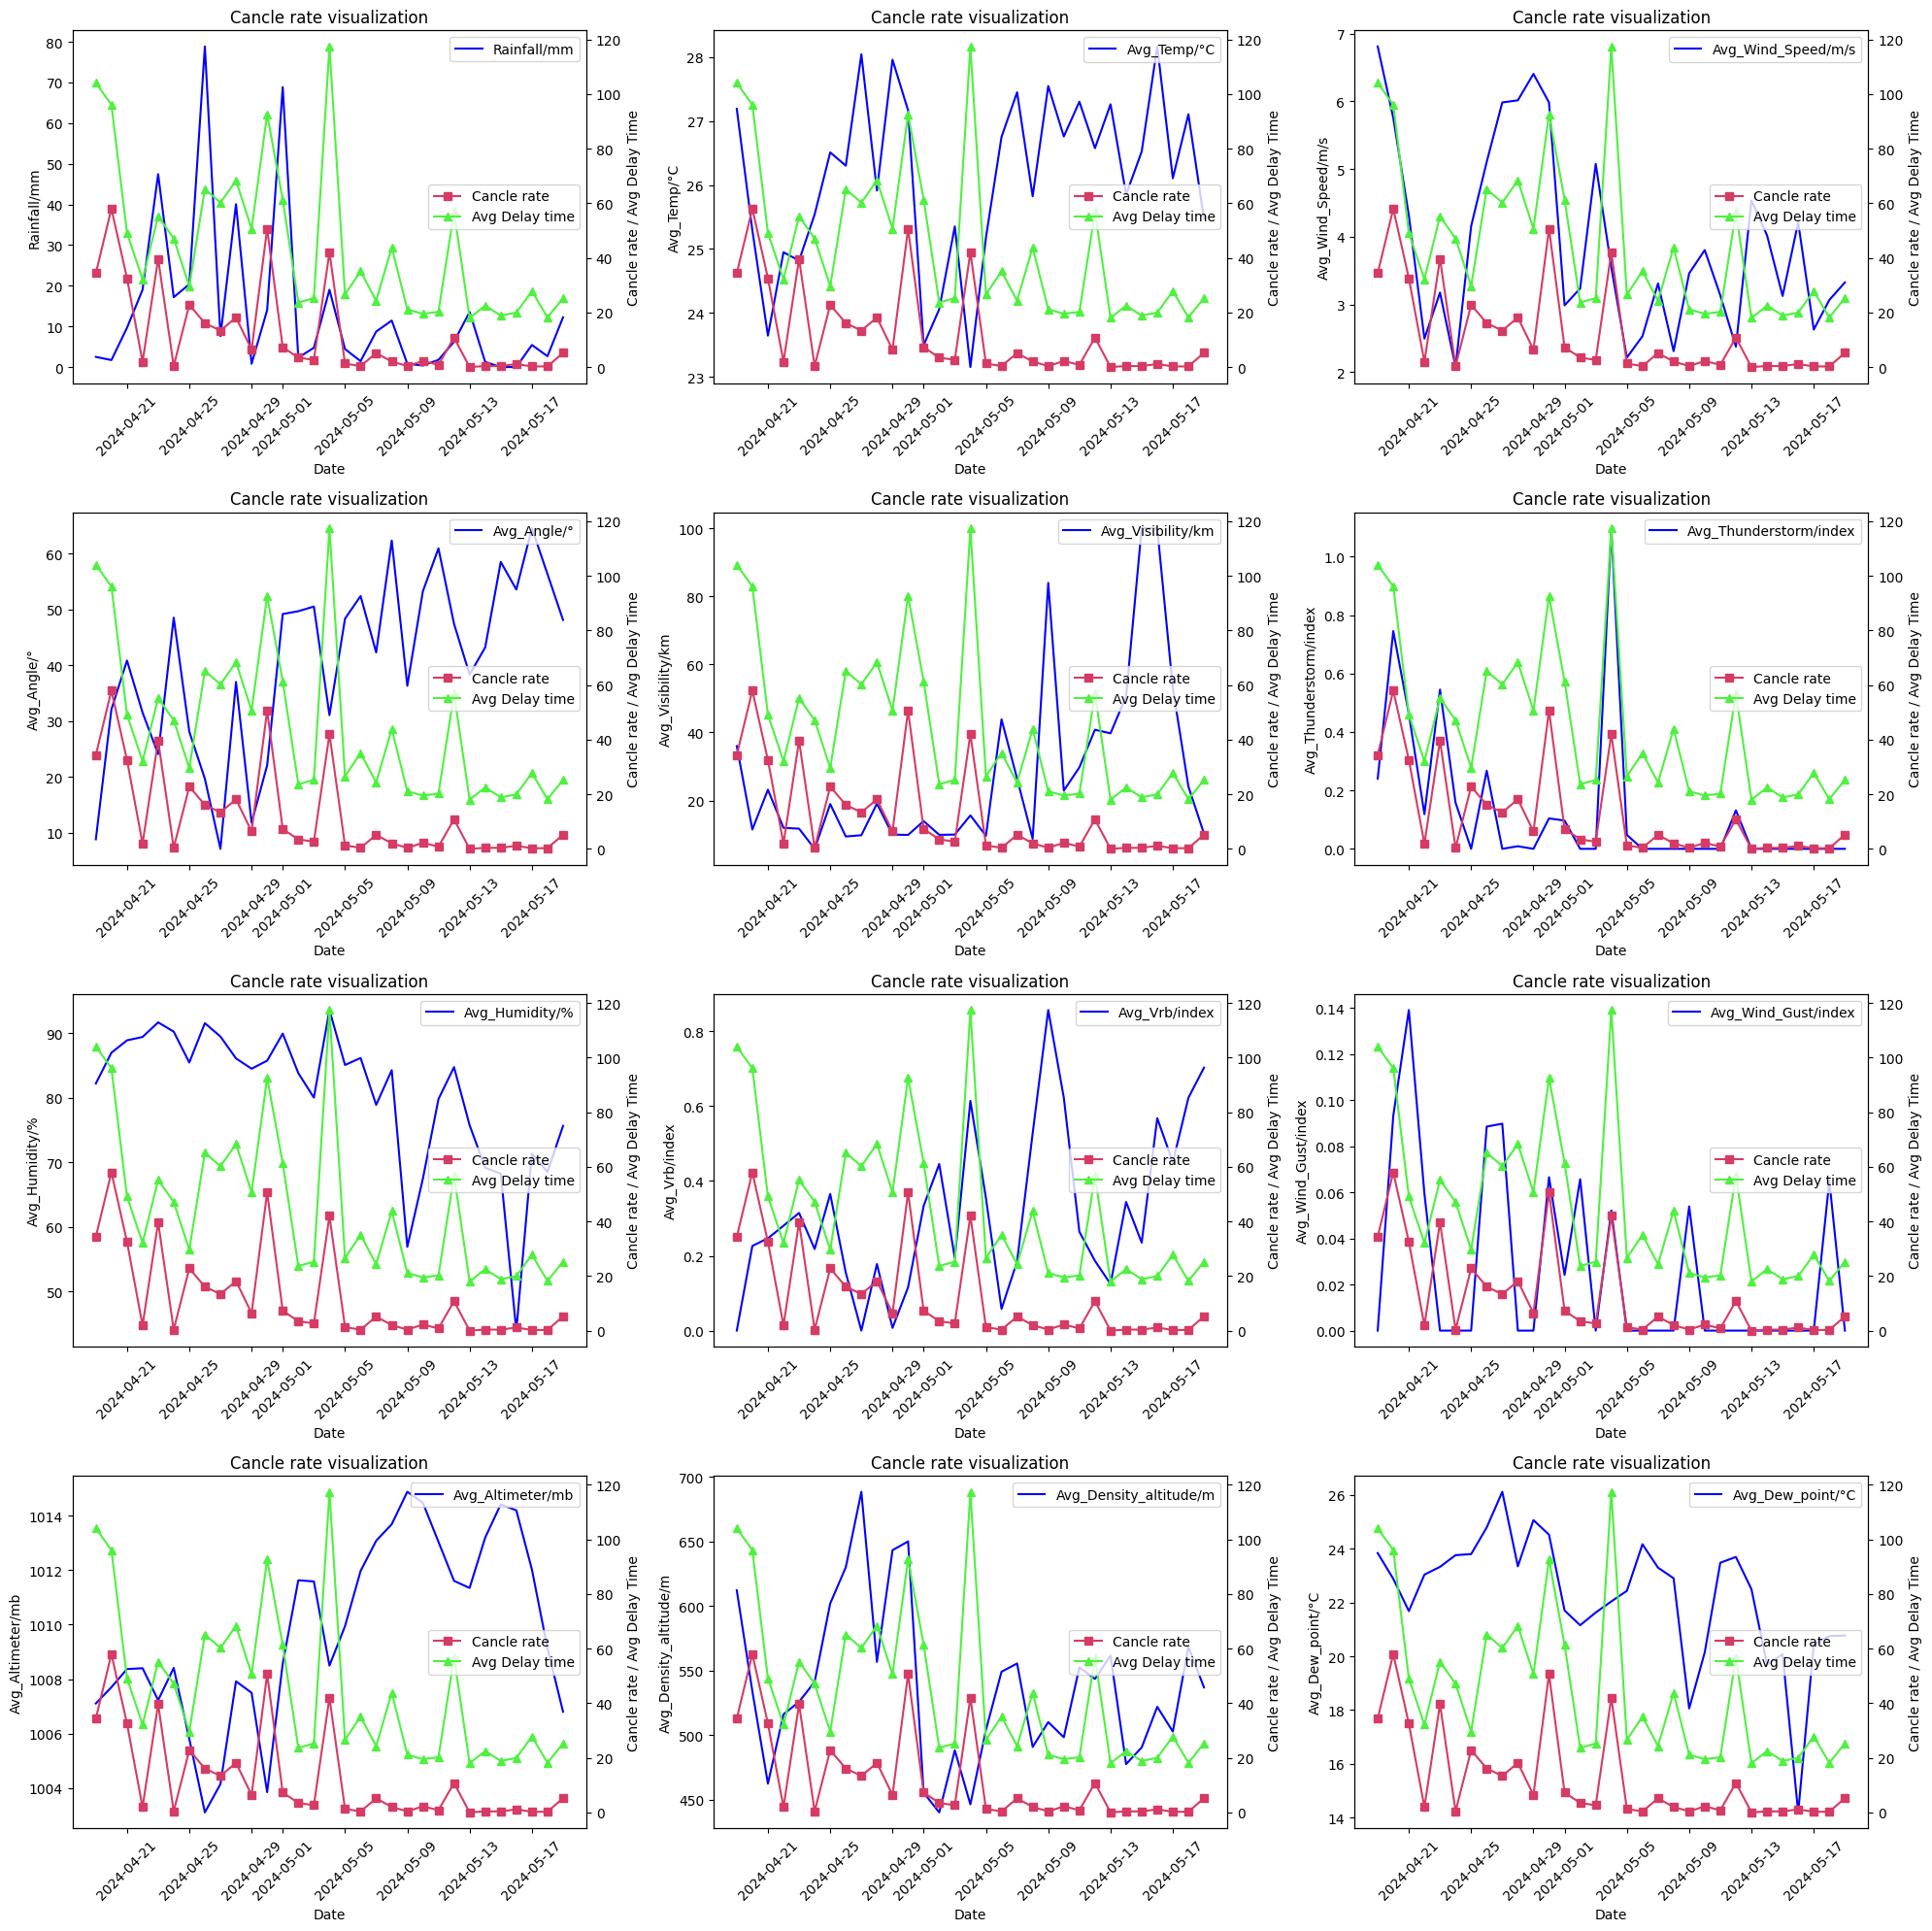

In [319]:
flightdate = Cancle_Daily["flightDate"]

indicators = [
    "Rainfall/mm",
    "Avg_Temp/°C",
    "Avg_Wind_Speed/m/s",
    "Avg_Angle/°",
    "Avg_Visibility/km",
    "Avg_Thunderstorm/index",
    "Avg_Humidity/%",
    "Avg_Vrb/index",
    "Avg_Wind_Gust/index",
    "Avg_Altimeter/mb",
    "Avg_Density_altitude/m",
    "Avg_Dew_point/°C"
]

# 创建子图布局
fig, axs = plt.subplots(4, 3, figsize=(20, 20))

for i, indicator in enumerate(indicators):
    row = i // 3
    col = i % 3

    ax = axs[row, col]
    ax.plot(
        flightdate,
        Cancle_Daily[indicator],
        color="b",
        label=indicator,
    )
    ax.set_xlabel("Date")
    ax.set_ylabel(indicator)
    ax.set_title("Cancle rate visualization")
    ax.legend(loc="upper right")
    ax.tick_params(axis="x", rotation=45)

    # Create a secondary y-axis for Cancle rate
    ax_secondary = ax.twinx()
    ax_secondary.plot(
        flightdate,
        Cancle_Daily["Cancle_rate"] * 100,
        color="#d53b64",
        marker="s",
        label="Cancle rate",
    )
    ax_secondary.plot(
        flightdate,
        -Cancle_Daily["Avg_Delaytime"],
        color="#4ef13f",
        marker="^",
        label="Avg Delay time",
    )

    ax_secondary.set_ylabel("Cancle rate / Avg Delay Time")
    ax_secondary.legend(loc="center right")

plt.tight_layout()
plt.show()